In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [2]:
train_X = pd.read_csv('/kaggle/input/ai-cup-dataset/train_X.csv')

train_X

,LocationCode,direction,temp_cwb,rad_cwb,apparent_zenith,apparent_elevation,azimuth,ghi,dni,dhi,day_of_year,hour,min
0,1,181.0,14.5,0.0,91.917932,-1.917932,114.450417,0.000000,0.000000,0.000000,1,6,31
1,1,181.0,14.5,0.0,91.709992,-1.709992,114.548622,0.000000,0.000000,0.000000,1,6,32
2,1,181.0,14.5,0.0,91.502216,-1.502216,114.647162,0.000000,0.000000,0.000000,1,6,33
3,1,181.0,14.5,0.0,91.294603,-1.294603,114.746037,0.000000,0.000000,0.000000,1,6,34
4,1,181.0,14.5,0.0,91.087156,-1.087156,114.845251,0.000000,0.000000,0.000000,1,6,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302361,17,NaN,31.6,1.8,47.554966,42.445034,278.396905,594.551396,677.751829,137.148378,194,15,26
1302362,17,NaN,31.6,1.8,47.784701,42.215299,278.469019,591.250877,676.329372,136.812645,194,15,27
1302363,17,NaN,31.6,1.8,48.010628,41.989372,278.539940,587.994166,674.916117,136.480078,194,15,28
1302364,17,NaN,31.6,1.8,48.236514,41.763486,278.610851,584.727322,673.488707,136.145177,194,15,29


In [3]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302366 entries, 0 to 1302365
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   LocationCode        1302366 non-null  int64  
 1   direction           1209685 non-null  float64
 2   temp_cwb            1302366 non-null  float64
 3   rad_cwb             1302366 non-null  float64
 4   apparent_zenith     1302366 non-null  float64
 5   apparent_elevation  1302366 non-null  float64
 6   azimuth             1302366 non-null  float64
 7   ghi                 1302366 non-null  float64
 8   dni                 1302366 non-null  float64
 9   dhi                 1302366 non-null  float64
 10  day_of_year         1302366 non-null  int64  
 11  hour                1302366 non-null  int64  
 12  min                 1302366 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 129.2 MB


In [4]:
train_y = pd.read_csv('/kaggle/input/ai-cup-dataset/train_y.csv')

train_y

,Power(mW)
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00
...,...
1302361,35.91
1302362,38.23
1302363,39.95
1302364,38.51


In [5]:
valid_X = pd.read_csv('/kaggle/input/ai-cup-dataset/valid_X.csv')
valid_y = pd.read_csv('/kaggle/input/ai-cup-dataset/valid_y.csv')

In [6]:
num_of_epochs = 100000  # epochs
num_of_stopping = int(num_of_epochs/100)

params = {
    'objective': 'regression', # 設置迴歸任務
    'metric': 'mae',           # 評估指標
    # 'boosting_type': 'dart',   # 使用, 預設 gbdt(傳統梯度提升決策樹); rf(隨機森林), dart(Dropout 搭配 MART)
    
    # 'num_leaves': 31,          # 每棵樹的最大葉子節點數, 預設 31
    
    # 'learning_rate': 0.05,     # 學習率, 預設 0.1

    # 'drop_rate': 0.1,          # 每次迭代丟棄樹的比例, 預設 0.1
    # 'max_drop': 50,            # 最多丟棄樹的數量, 預設 50
    # 'skip_drop': 0.5,          # 跳過丟棄的概率, 預設 0.5
    
    # 'feature_fraction': 0.9,   # 每棵樹隨機選擇的特徵比例, 預設 1.0
    # 'bagging_fraction': 0.8,   # 每次迭代抽樣的數據比例, 預設 1.0
    # 'bagging_freq': 5,         # 每隔多少次迭代執行 bagging
    
    'verbose': 0,              # 不輸出訓練信息
    'random_state': 42,
}

In [7]:
# 進行 5 Folds Cross Validation，可以選擇是否使用
kf = KFold(n_splits=5, shuffle=True, random_state=42)

loss_folds = []
for train_idx, valid_idx in kf.split(train_X):    
    fold_train_X, fold_valid_X = train_X.iloc[train_idx], train_X.iloc[valid_idx]
    fold_train_y, fold_valid_y = train_y.iloc[train_idx], train_y.iloc[valid_idx]

    fold_train_data = lgb.Dataset(fold_train_X, label=fold_train_y)
    fold_valid_data = lgb.Dataset(fold_valid_X, label=fold_valid_y, reference=fold_train_data)

    model = lgb.train(
        params,
        fold_train_data,
        num_of_epochs,
        valid_sets=[fold_train_data, fold_valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=num_of_stopping),
        ]
    )
    
    predi_valid = model.predict(fold_valid_X)

    loss = mean_absolute_error(fold_valid_y, predi_valid)
    
    loss_folds.append(round(loss, 4))

    print(f'Fold {len(loss_folds)} loss : {round(loss, 4)}')

print(sum(loss_folds)/len(loss_folds))

Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[70434]	training's l1: 19.4008	valid_1's l1: 39.4786
Fold 1 loss : 39.4786
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[69997]	training's l1: 19.5436	valid_1's l1: 39.6216
Fold 2 loss : 39.6216
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[83249]	training's l1: 18.1285	valid_1's l1: 39.6134
Fold 3 loss : 39.6134
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[77641]	training's l1: 18.7418	valid_1's l1: 39.4512
Fold 4 loss : 39.4512
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[83923]	training's l1: 18.0944	valid_1's l1: 39.6619
Fold 5 loss : 39.6619
39.565340000000006


In [8]:
train_data = lgb.Dataset(train_X, label=train_y)
valid_data = lgb.Dataset(valid_X, label=valid_y, reference=train_data)

In [9]:
loss_history = {}

model = lgb.train(
    params,
    train_data,
    num_of_epochs,
    valid_sets=[train_data, valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=num_of_stopping),
        lgb.record_evaluation(loss_history),
    ]
)

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[100000]	training's l1: 17.6386	valid_1's l1: 15.9202


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

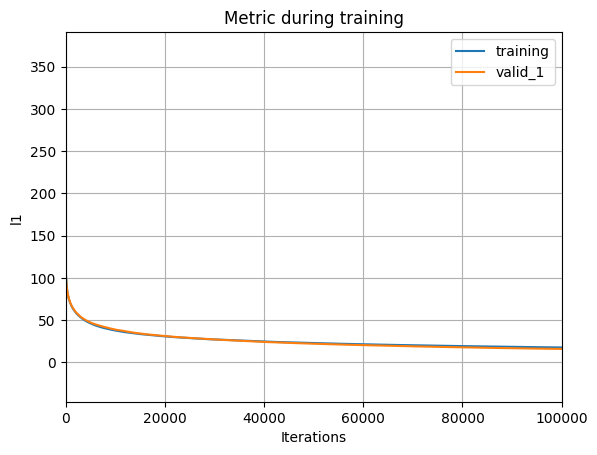

In [10]:
lgb.plot_metric(loss_history)

In [11]:
predi = model.predict(valid_X)

In [12]:
loss = mean_absolute_error(valid_y, predi)

loss = round(loss, 4)

loss

15.9202

In [13]:
feature_importance = pd.DataFrame({
    'feature': train_X.columns,
    'importance': model.feature_importance('gain')
})

feature_importance = feature_importance.sort_values(
    'importance', ascending=False
)

feature_importance

,feature,importance
3,rad_cwb,8.880538e+11
0,LocationCode,2.057688e+11
6,azimuth,1.141178e+11
1,direction,9.560501e+10
10,day_of_year,7.326189e+10
11,hour,5.062707e+10
8,dni,4.562579e+10
2,temp_cwb,4.129247e+10
12,min,3.757769e+10
9,dhi,3.218108e+10


---

# Testset preidiction

In [14]:
testdata_1min = pd.read_csv('/kaggle/input/ai-cup-dataset/testdata_1min.csv')

testdata_1min

,LocationCode,direction,temp_cwb,rad_cwb,apparent_zenith,apparent_elevation,azimuth,ghi,dni,dhi,day_of_year,hour,min
0,1,181.0,17.3,0.8,63.247668,26.752332,131.288622,429.514615,785.797366,75.799813,17,9,0
1,1,181.0,17.3,0.8,63.076108,26.923892,131.466204,432.685234,787.611928,76.049325,17,9,1
2,1,181.0,17.3,0.8,62.905017,27.094983,131.644626,435.843357,789.402018,76.296758,17,9,2
3,1,181.0,17.3,0.8,62.734401,27.265599,131.823892,438.988892,791.168037,76.542132,17,9,3
4,1,181.0,17.3,0.8,62.564262,27.435738,132.004007,442.121752,792.910382,76.785470,17,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,12,298.0,22.7,0.1,80.635190,9.364810,261.543228,80.074206,234.876783,41.854924,276,16,55
95996,12,298.0,22.7,0.1,80.861445,9.138555,261.649731,76.614636,226.626384,40.621142,276,16,56
95997,12,298.0,22.7,0.1,81.087760,8.912240,261.756031,73.191495,218.305735,39.371129,276,16,57
95998,12,298.0,22.7,0.1,81.314136,8.685864,261.862134,69.806874,209.920720,38.105162,276,16,58


In [15]:
testdata_1min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96000 entries, 0 to 95999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LocationCode        96000 non-null  int64  
 1   direction           84480 non-null  float64
 2   temp_cwb            96000 non-null  float64
 3   rad_cwb             96000 non-null  float64
 4   apparent_zenith     96000 non-null  float64
 5   apparent_elevation  96000 non-null  float64
 6   azimuth             96000 non-null  float64
 7   ghi                 96000 non-null  float64
 8   dni                 96000 non-null  float64
 9   dhi                 96000 non-null  float64
 10  day_of_year         96000 non-null  int64  
 11  hour                96000 non-null  int64  
 12  min                 96000 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 9.5 MB


In [16]:
result_1min = model.predict(testdata_1min)

print(result_1min[:10])
print(result_1min[10:20])

print(result_1min[-20:-10])
print(result_1min[-10:])

[ 95.87434298 113.10442683 116.24636846 128.28633547 141.68017615
 161.29094925 241.23675514 237.63494696 182.42608286 176.64610501]
[243.41095958 223.80488203 206.25023268 147.95018631 140.93150823
 162.5407458  141.8594794  128.5175226  117.13444265 148.81383332]
[ 1.1152914   0.76134363  0.62387951 -0.82740646 -0.4395541  -0.0714302
 -1.03750849 -0.79382843 -1.16672856 -0.97971576]
[ 0.53646272  0.35236924  2.82019912 -1.1397193  -0.42438356 -1.06157533
 -0.44745998  0.55108584  0.13365381  8.62709459]


In [17]:
result_avg = [max(round(sum(result_1min[i:i+10])/10, 2), 0) for i in range(0, len(result_1min), 10)]

print(result_avg[:15])
print(result_avg[-15:])

[159.44, 166.12, 129.18, 218.52, 249.15, 231.15, 481.73, 505.13, 587.26, 629.26, 693.55, 903.39, 69.97, 60.95, 50.87]
[25.7, 7.5, 14.03, 8.8, 13.76, 16.52, 10.19, 5.38, 5.45, 4.69, 3.87, 3.96, 2.14, 0, 0.99]


In [18]:
testset = pd.read_csv('/kaggle/input/ai-cup-original-testset/upload(no answer).csv')

testset['序號'] = testset['序號'].astype('str')

testset

,序號,答案
0,20240117090001,NaN
1,20240117091001,NaN
2,20240117092001,NaN
3,20240117093001,NaN
4,20240117094001,NaN
...,...,...
9595,20241002161012,NaN
9596,20241002162012,NaN
9597,20241002163012,NaN
9598,20241002164012,NaN


In [19]:
testset['答案'] = result_avg

testset

,序號,答案
0,20240117090001,159.44
1,20240117091001,166.12
2,20240117092001,129.18
3,20240117093001,218.52
4,20240117094001,249.15
...,...,...
9595,20241002161012,3.87
9596,20241002162012,3.96
9597,20241002163012,2.14
9598,20241002164012,0.00


In [20]:
testset.to_csv('upload_1min.csv', index=False)

print('testset 1min saved')

testset 1min saved


---

In [21]:
model.save_model(f'LGBM_{num_of_epochs}e_{loss}.json')  # 存成 JSON 格式